In [1]:
## conda env Weather_Prediction

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import xarray as xr
import rioxarray ## what we need from rioxarray can be done using rio acessor
import regionmask

In [2]:
## lets load the data

data = xr.open_dataset("data_sfc.nc")
data

<xarray.Dataset> Size: 63MB
Dimensions:     (valid_time: 2920, latitude: 34, longitude: 79)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 23kB 2010-01-01 ... 2010-12-31T21...
  * latitude    (latitude) float64 272B 48.75 48.0 47.25 ... 25.5 24.75 24.0
  * longitude   (longitude) float64 632B -125.0 -124.2 -123.5 ... -67.25 -66.5
Data variables:
    d2m         (valid_time, latitude, longitude) float32 31MB ...
    t2m         (valid_time, latitude, longitude) float32 31MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-30T01:51 GRIB to CDM+CF via cfgrib-0.9.1...

##  Lets begin by visualizing the data

In [3]:
## the data is multi-dimensional. the plot will be for an instant of time in a grid
# Slice the data by time and just the single variable for plotting purposes

instant = "2010-01-01T00:00:00.000000000"

instant_data = data["t2m"].sel(valid_time=slice(instant))
instant_data

<xarray.DataArray 't2m' (valid_time: 1, latitude: 34, longitude: 79)> Size: 11kB
[2686 values with dtype=float32]
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 8B 2010-01-01
  * latitude    (latitude) float64 272B 48.75 48.0 47.25 ... 25.5 24.75 24.0
  * longitude   (longitude) float64 632B -125.0 -124.2 -123.5 ... -67.25 -66.5
Attributes: (12/33)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      2686
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_number:                              0
    GRIB_surface:                             0.0

In [4]:
crs=instant_data.rio.crs ## the rio accessor
print(crs)  ## note that there no associated crs with the data

None


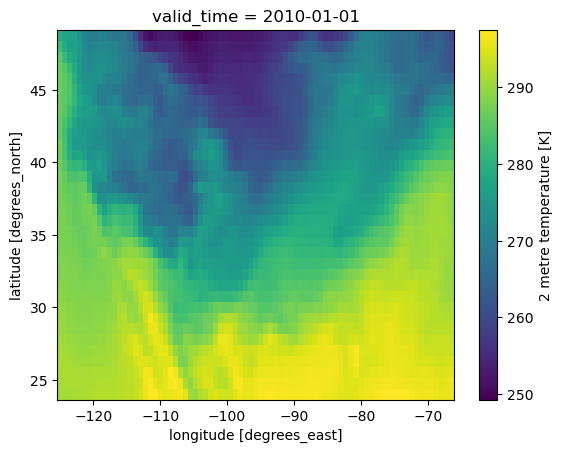

In [5]:
## an average plot

instant_data.plot() 

Text(0.5, 1.0, '2m Temperature on Jan 1 at 2010 00:00')

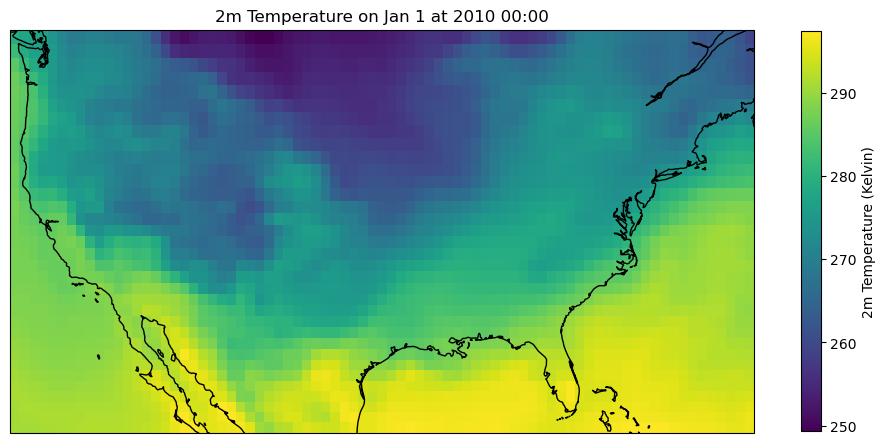

In [39]:
## improve the plot quality

fig = plt.figure(figsize=(12, 8))

p=instant_data.plot(subplot_kws=dict(projection=ccrs.Mercator()),  ## projection of the p
                                      transform=ccrs.PlateCarree(),
                                       cbar_kwargs={"label": "2m Temperature (Kelvin)",'shrink':0.65})
p.axes.coastlines()
plt.title('2m Temperature on Jan 1 at 2010 00:00')

#### Note the fact that, in the figure below,  despite the fact that the data was downloaded over a rectangle, when it is projected in the AlbersEqualArea projection, the raster gets curved

Text(0.5, 1.0, '2m Temperature on Jan 1 2010 at 00:00')

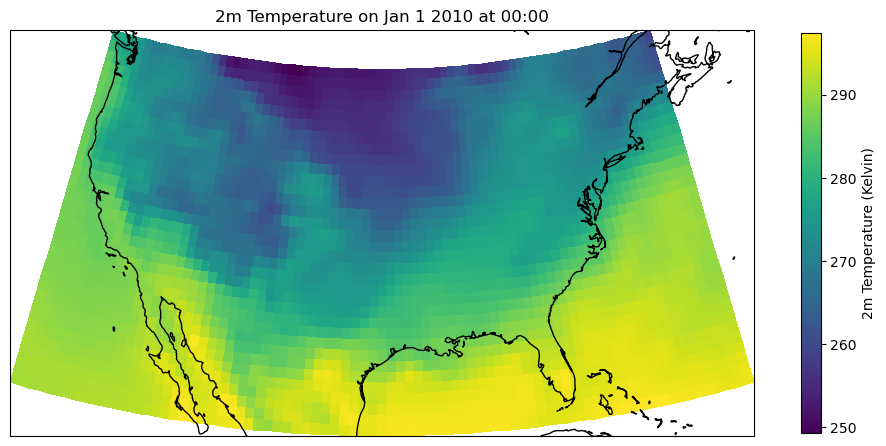

In [9]:
## Plot it in AlbersEqualArea projection

extent=[-125, -66.5, 48.75,24 ] ## the extent of CONUS data that is also shown in the dataset named "data"

central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig = plt.figure(figsize=(12, 8))

p=instant_data.plot(subplot_kws=dict({'projection':ccrs.AlbersEqualArea(central_lon, central_lat)}),
                                        transform=ccrs.PlateCarree(), 
                                          cbar_kwargs={"label": "2m Temperature (Kelvin)",'shrink':0.65} )

p.axes.coastlines()
plt.title('2m Temperature on Jan 1 2010 at 00:00')

#### Include state in the raster plot

In [10]:
## Lets load the shapefile

SHAPE_PATH = os.path.join("State_shapefile",'cb_2018_us_state_500k.shp')
state_shape = gpd.read_file(SHAPE_PATH)

print('The CRS of the SHAPE file is:', state_shape.crs)

The CRS of the SHAPE file is: EPSG:4269


In [16]:
state_shape=state_shape.to_crs(3857)
state_shapes=state_shape.drop([13,27, 36, 37, 38,42, 44, 45 ])